In [1]:
import graphlab
import matplotlib.pyplot as plt
%matplotlib inline
from math import log
from math import exp

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
/opt/conda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/opt/conda/lib/python2.7/site-packages/requests/packages/urllib3/connection.py:266: SubjectAltNameWarning: Certificate for beta.graphlab.com has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/shazow/urllib3/issues/497 for details.)
  SubjectAltNameWarning
[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1500830692.log


This non-commercial license of GraphLab Create for academic use is assigned to mukesh.mithrakumar@jacks.sdstate.edu and will expire on June 17, 2018.


/opt/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
loans = graphlab.SFrame('sub_lending-club-data.csv')

Finished parsing file /home/jovyan/work/Course3/Week5/sub_lending-club-data.csv

Parsing completed. Parsed 100 lines in 1.78466 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,str,float,float,str,str,str,str,str,int,str,str,str,str,str,str,str,str,str,str,float,int,str,int,int,int,int,int,int,float,int,str,float,float,float,float,float,float,float,float,float,str,float,str,str,int,str,int,int,str,int,int,int,int,float,int,int,int,int,float,str,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/jovyan/work/Course3/Week5/sub_lending-club-data.csv

Parsing completed. Parsed 37892 lines in 0.992861 secs.

In [3]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans.remove_column('bad_loans')
target = 'safe_loans'
loans = loans[features + [target]]

In [4]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

# Undersample the safe loans.
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
risky_loans = risky_loans_raw
safe_loans = safe_loans_raw.sample(percentage, seed=1)
loans_data = risky_loans_raw.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.500912778905
Percentage of risky loans                : 0.499087221095
Total number of loans in our new dataset : 9860


In [5]:
loans_data = risky_loans.append(safe_loans)
for feature in features:
    loans_data_one_hot_encoded = loans_data[feature].apply(lambda x: {x: 1})    
    loans_data_unpacked = loans_data_one_hot_encoded.unpack(column_name_prefix=feature)
    
    # Change None's to 0's
    for column in loans_data_unpacked.column_names():
        loans_data_unpacked[column] = loans_data_unpacked[column].fillna(0)

    loans_data.remove_column(feature)
    loans_data.add_columns(loans_data_unpacked)

In [6]:
features = loans_data.column_names()
features.remove('safe_loans')  # Remove the response variable

In [7]:
train_data, test_data = loans_data.random_split(0.8, seed=1)

In [31]:
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    total_weight_positive = sum(data_weights[labels_in_node == +1])
    #print total_weight_positive
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    weighted_mistakes_all_negative = (total_weight_positive)
    
    # Sum the weights of all entries with label -1
    total_weight_negative = sum(data_weights[labels_in_node == -1])
    #print total_weight_negative
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    weighted_mistakes_all_positive = (total_weight_negative)
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    if weighted_mistakes_all_negative <= weighted_mistakes_all_positive:
        return (weighted_mistakes_all_negative, -1)
    else:
        return (weighted_mistakes_all_positive, +1)

In [32]:
# test intermediate_node_weighted_mistakes function
example_labels = graphlab.SArray([-1, -1, 1, 1, 1])
example_data_weights = graphlab.SArray([1., 2., .5, 1., 1.])
if intermediate_node_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print 'Test passed!'
else:
    print 'Test failed... try again!'


Test passed!


In [35]:
def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights)
        right_weighted_mistakes, right_class =intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        error = (left_weighted_mistakes + right_weighted_mistakes) / (sum(left_data_weights) + sum(right_data_weights))
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

In [34]:
# test best_splitting_feature function 

example_data_weights = graphlab.SArray(len(train_data)* [1.5])
if best_splitting_feature(train_data, features, target, example_data_weights) == 'term. 36 months':
    print 'Test passed!'
else:
    print 'Test failed... try again!'

Test failed... try again!


In [36]:
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class
    
    return leaf

In [37]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print "--------------------------------------------------------------------"
    print "Subtree, depth = %s (%s data points)." % (current_depth, len(target_values))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print "Stopping condition 1 reached."                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print "Stopping condition 2 reached."                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print "Reached maximum depth. Stopping for now."
        return create_leaf(target_values, data_weights)
    
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print "Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print "Creating leaf node."
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print "Creating leaf node."
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [38]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [39]:
example_data_weights = graphlab.SArray([1.0 for i in range(len(train_data))])
small_data_decision_tree = weighted_decision_tree_create(train_data, features, target,
                                        example_data_weights, max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print 'Test passed!'
else:
    print 'Test failed... try again!'
    print 'Number of nodes found:', count_nodes(small_data_decision_tree)
    print 'Number of nodes that should be there: 7' 

--------------------------------------------------------------------
Subtree, depth = 1 (7906 data points).
Split on feature term.36 months. (2299, 5607)
--------------------------------------------------------------------
Subtree, depth = 2 (2299 data points).
Split on feature grade.A. (2247, 52)
--------------------------------------------------------------------
Subtree, depth = 3 (2247 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (52 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5607 data points).
Split on feature grade.E. (5398, 209)
--------------------------------------------------------------------
Subtree, depth = 3 (5398 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (209 data points).
Rea

In [40]:
#a function that classifies one data point. It can also return the probability if you want to play around with that as well.

def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print "At leaf, predicting %s" % tree['prediction']
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x[tree['splitting_feature']]
        if annotate: 
            print "Split on %s = %s" % (tree['splitting_feature'], split_feature_value)
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

In [41]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, x))
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [43]:
# Assign weights
example_data_weights = graphlab.SArray([1.] * 10 + [0.]*(len(train_data) - 20) + [1.] * 10)

# Train a weighted decision tree model.
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, features, target,
                         example_data_weights, max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (7906 data points).
Split on feature home_ownership.RENT. (4065, 3841)
--------------------------------------------------------------------
Subtree, depth = 2 (4065 data points).
Split on feature grade.F. (3920, 145)
--------------------------------------------------------------------
Subtree, depth = 3 (3920 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (145 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (3841 data points).
Split on feature grade.D. (3203, 638)
--------------------------------------------------------------------
Subtree, depth = 3 (3203 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 3 (638 data points).
Stopping condition

In [44]:
subset_20 = train_data.head(10).append(train_data.tail(10))
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20)

0.05

In [45]:
evaluate_classification_error(small_data_decision_tree_subset_20, train_data)

0.49000758917278014

In [46]:
def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = graphlab.SArray([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in xrange(num_tree_stumps):
        print '====================================================='
        print 'Adaboost Iteration %d' % t
        print '====================================================='        
        # Learn a weighted decision tree stump. Use max_depth=1
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        predictions = data.apply(lambda x: classify(tree_stump, x))
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        weighted_error = sum(alpha[is_wrong])/sum(alpha)
        
        # Compute model coefficient using weighted error
        weight = 0.5*log((1-weighted_error)/ weighted_error)
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment 
        # Then normalize data points weights
        alpha = alpha*adjustment/float(sum(alpha))
    return weights, tree_stumps

In [47]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, target, num_tree_stumps=2)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (7906 data points).
Split on feature term.36 months. (2299, 5607)
--------------------------------------------------------------------
Subtree, depth = 2 (2299 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5607 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (7906 data points).
Split on feature grade.A. (6237, 1669)
--------------------------------------------------------------------
Subtree, depth = 2 (6237 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (1669 data points).
Reached maximum depth. Stopping for now.


In [48]:
def print_stump(tree):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print "(leaf, label: %s)" % tree['prediction']
        return None
    split_feature, split_value = split_name.split('.')
    print '                       root'
    print '         |---------------|----------------|'
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '  [{0} == 0]{1}[{0} == 1]    '.format(split_name, ' '*(27-len(split_name)))
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '    (%s)                 (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree'))

In [49]:
print_stump(tree_stumps[0])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term.36 months == 0]             [term.36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [50]:
print stump_weights

[0.2792365363102084, 0.21591726282606347]


In [51]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, features, 
                                target, num_tree_stumps=10)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (7906 data points).
Split on feature term.36 months. (2299, 5607)
--------------------------------------------------------------------
Subtree, depth = 2 (2299 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5607 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (7906 data points).
Split on feature grade.A. (6237, 1669)
--------------------------------------------------------------------
Subtree, depth = 2 (6237 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (1669 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
----------------------------------------

In [52]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = graphlab.SArray([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, x))
        scores =+ (stump_weights[i] * predictions)
        
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [53]:
predictions = predict_adaboost(stump_weights, tree_stumps, test_data)
accuracy = graphlab.evaluation.accuracy(test_data[target], predictions)
print 'Accuracy of 10-component ensemble = %s' % accuracy 

Accuracy of 10-component ensemble = 0.49692937564


In [54]:
stump_weights

[0.2792365363102084,
 0.21591726282606347,
 0.07471714466114439,
 0.07319119696461102,
 0.06798779465536225,
 0.03328168638633913,
 0.029551421699701656,
 0.026660300089301373,
 0.02106338666631951,
 0.024073184490368518]

In [55]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data, 
                                 features, target, num_tree_stumps=30)

Adaboost Iteration 0
--------------------------------------------------------------------
Subtree, depth = 1 (7906 data points).
Split on feature term.36 months. (2299, 5607)
--------------------------------------------------------------------
Subtree, depth = 2 (2299 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (5607 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
--------------------------------------------------------------------
Subtree, depth = 1 (7906 data points).
Split on feature grade.A. (6237, 1669)
--------------------------------------------------------------------
Subtree, depth = 2 (6237 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (1669 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 2
----------------------------------------

In [56]:
error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data)
    error = 1.0 - graphlab.evaluation.accuracy(train_data[target], predictions)
    error_all.append(error)
    print "Iteration %s, training error = %s" % (n, error_all[n-1])

Iteration 1, training error = 0.363900834809
Iteration 2, training error = 0.404629395396
Iteration 3, training error = 0.476600050594
Iteration 4, training error = 0.484189223375
Iteration 5, training error = 0.478244371364
Iteration 6, training error = 0.404629395396
Iteration 7, training error = 0.455603339236
Iteration 8, training error = 0.476600050594
Iteration 9, training error = 0.485833544144
Iteration 10, training error = 0.526309132305
Iteration 11, training error = 0.484189223375
Iteration 12, training error = 0.498102706805
Iteration 13, training error = 0.484189223375
Iteration 14, training error = 0.404629395396
Iteration 15, training error = 0.473564381482
Iteration 16, training error = 0.476600050594
Iteration 17, training error = 0.526309132305
Iteration 18, training error = 0.484189223375
Iteration 19, training error = 0.544396660764
Iteration 20, training error = 0.490260561599
Iteration 21, training error = 0.404629395396
Iteration 22, training error = 0.4841892233

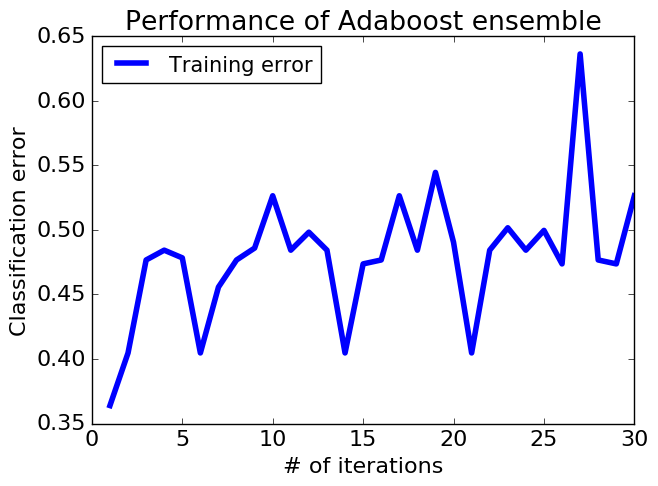

In [57]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

In [58]:
test_error_all = []
for n in xrange(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data)
    error = 1.0 - graphlab.evaluation.accuracy(test_data[target], predictions)
    test_error_all.append(error)
    print "Iteration %s, test error = %s" % (n, test_error_all[n-1])

Iteration 1, test error = 0.366427840328
Iteration 2, test error = 0.380757420676
Iteration 3, test error = 0.46110542477
Iteration 4, test error = 0.511258955988
Iteration 5, test error = 0.482088024565
Iteration 6, test error = 0.380757420676
Iteration 7, test error = 0.465199590583
Iteration 8, test error = 0.46110542477
Iteration 9, test error = 0.512282497441
Iteration 10, test error = 0.50307062436
Iteration 11, test error = 0.511258955988
Iteration 12, test error = 0.478505629478
Iteration 13, test error = 0.511258955988
Iteration 14, test error = 0.380757420676
Iteration 15, test error = 0.5
Iteration 16, test error = 0.46110542477
Iteration 17, test error = 0.50307062436
Iteration 18, test error = 0.511258955988
Iteration 19, test error = 0.534800409417
Iteration 20, test error = 0.530194472876
Iteration 21, test error = 0.380757420676
Iteration 22, test error = 0.511258955988
Iteration 23, test error = 0.482088024565
Iteration 24, test error = 0.511258955988
Iteration 25, tes

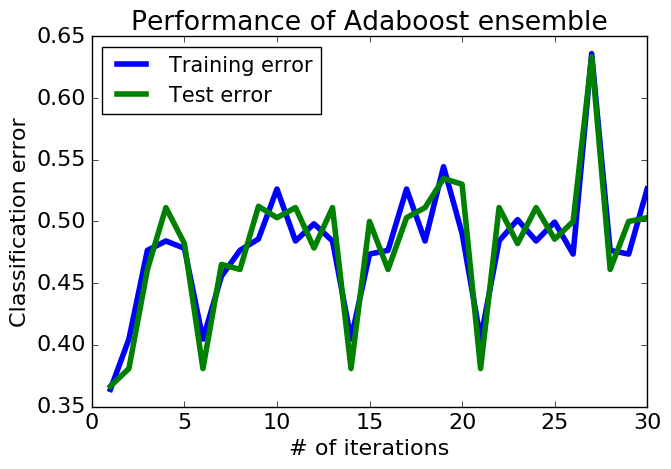

In [59]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()